In [1]:
import requests
import zipfile
import io

# Replace 'PASTE_DOWNLOAD_LINK_HERE' with the link address you copied from Kaggle
download_link = 'https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/54041/5884478/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1685798025&Signature=v0QEsAIohOoCkcb7g7HjoOyP0chNmrGvnVPFLrQ%2FplcxDu7Zw3W9nc5Vi%2F6py%2BFVeZRjPOKBSYgWP5euFgQ1MPV0aurOqem5ZmtnO4Mm6jG%2FLZya6pQxFuNcOGkKGSf2XHCeyvYSzAEfyac79dcPotLZb3fCFj2sHwYhk%2FLoustbB8tqxQKOxJ0ZE6PR6lA0tZe1WFiu7KVqEBRSb%2BK7zIBbjeTBuPzrVvfwvB3B4LeuXOPrJT%2Fk6hLid6Mw6tE%2FvhldtjrykN%2BktaMDojEtJYkqhW4Umnax8EbQbXPvbRtwUknrLY%2FNS14w4CtuUbRGSN9b2UR96ZEJBf5M82u%2Byw%3D%3D&response-content-disposition=attachment%3B+filename%3Dextracting-attributes-from-fashion-images-2.zip'

# Specify the file path where you want to save the downloaded data
save_path = 'data'

# Send a GET request to download the data
response = requests.get(download_link)

# Extract the contents of the zip file
zip_file = zipfile.ZipFile(io.BytesIO(response.content))
zip_file.extractall(save_path)

print('Data downloaded successfully!')

Data downloaded successfully!


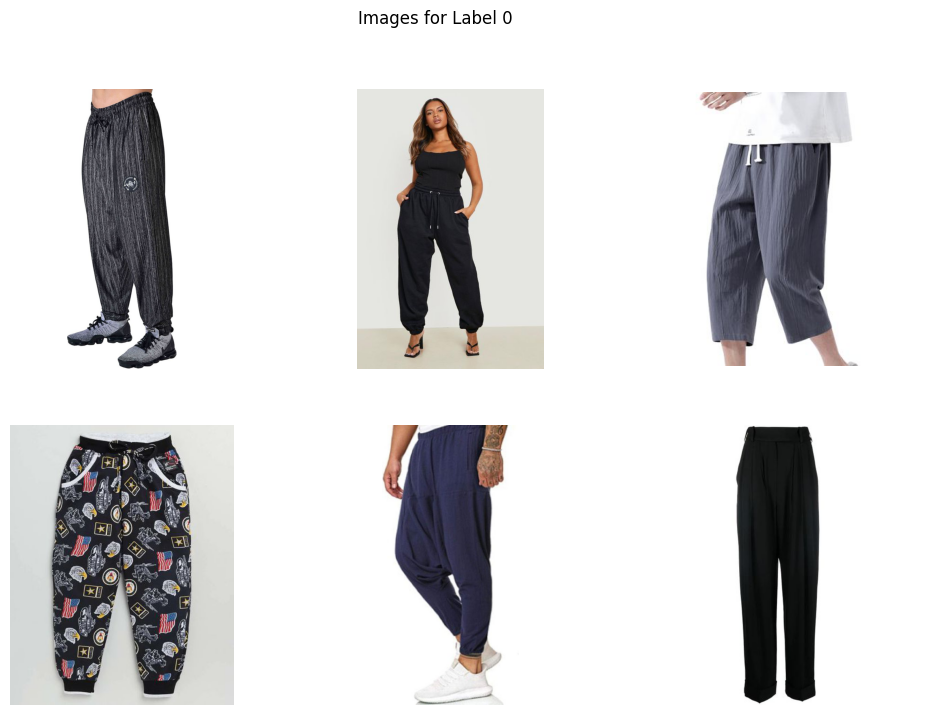

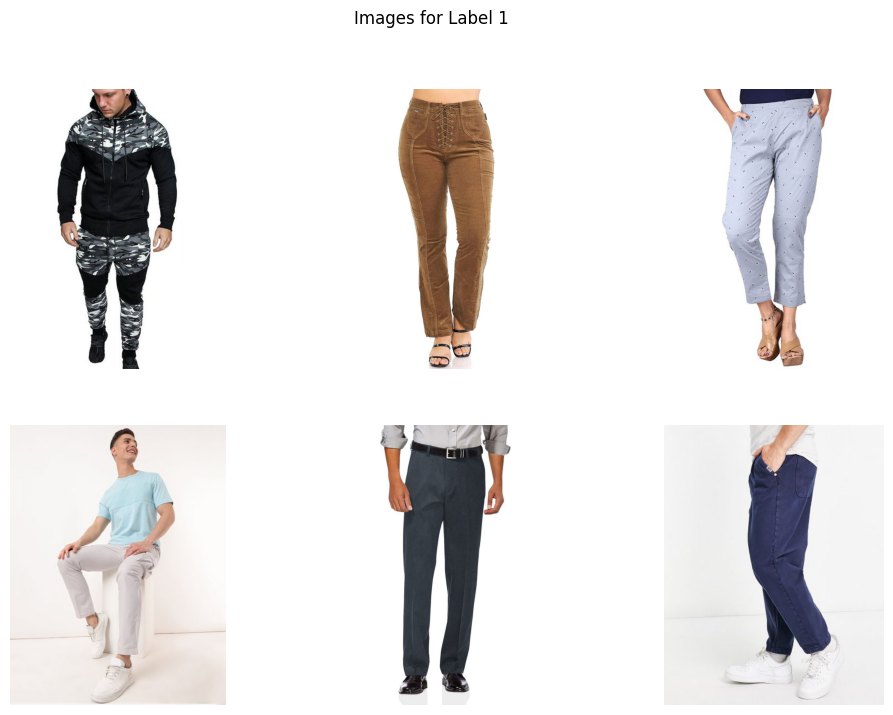

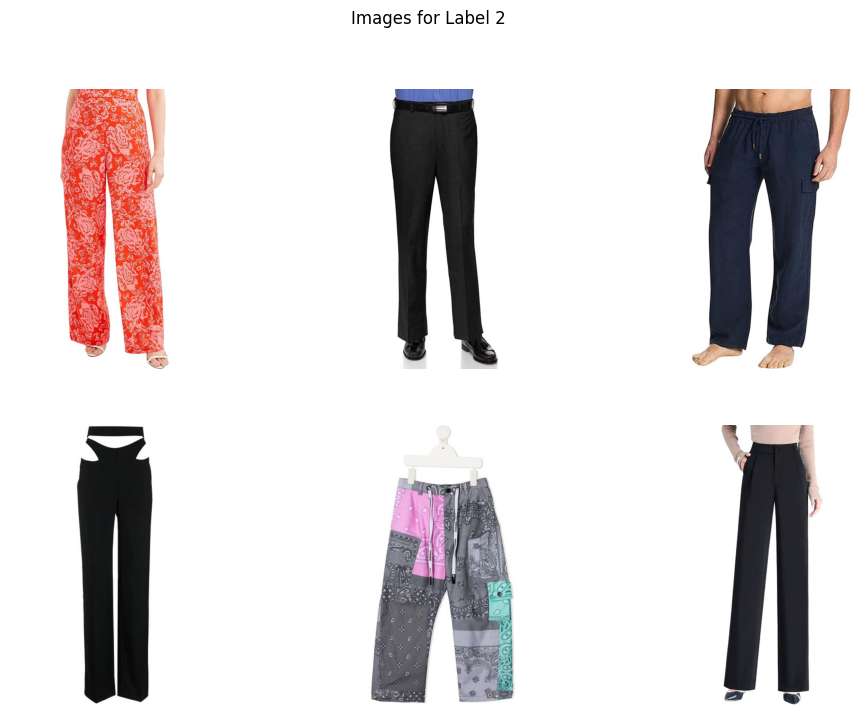

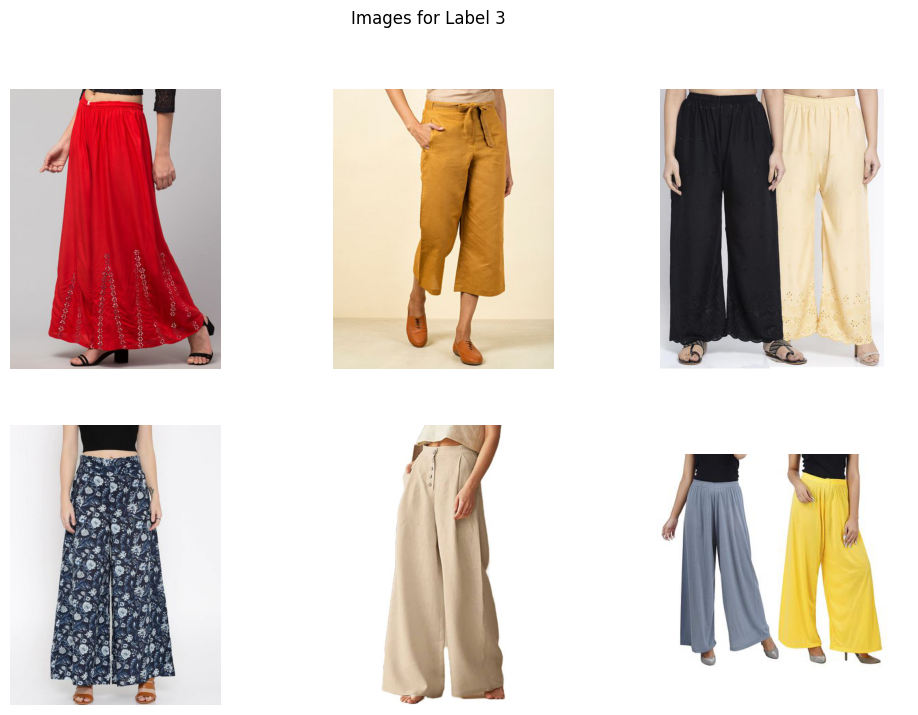

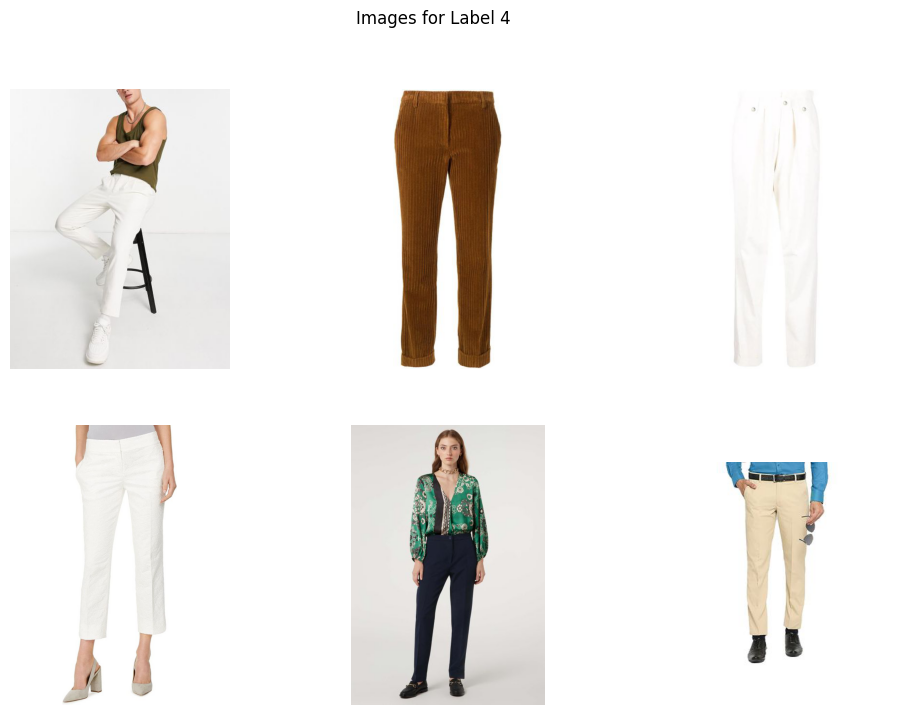

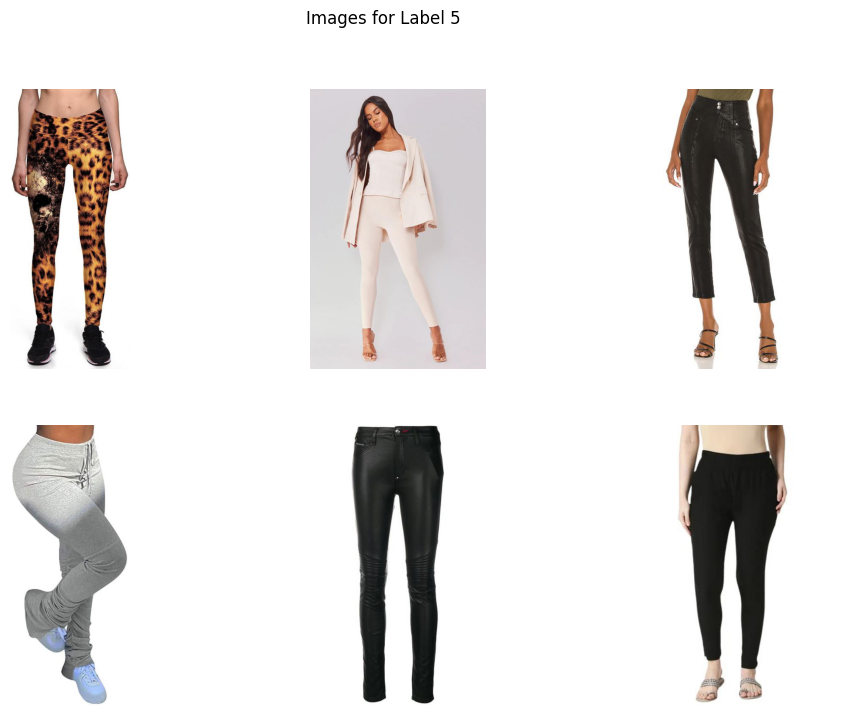

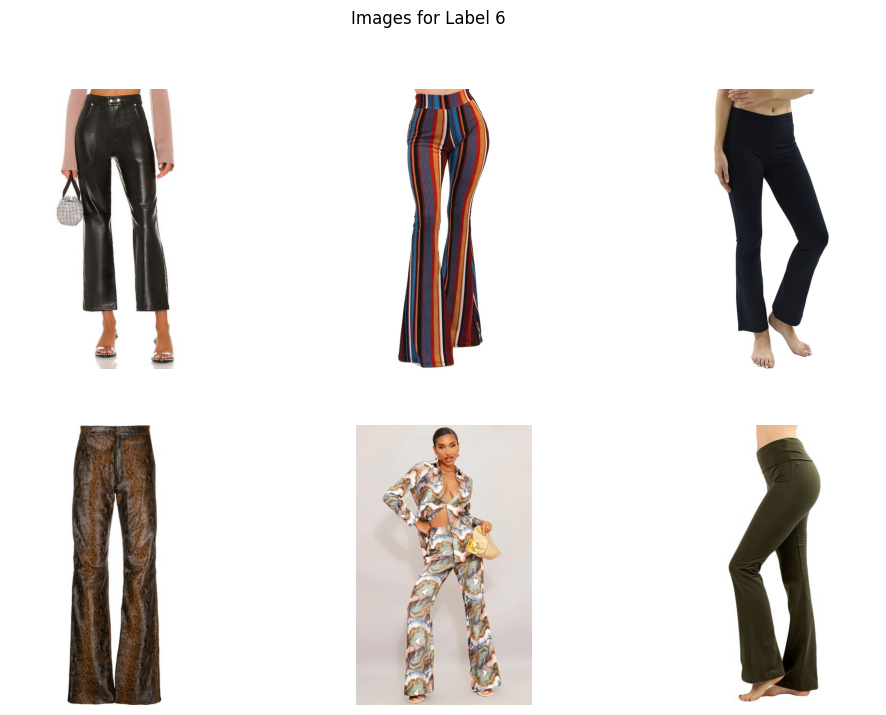

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image

# Path to the train folder containing the images
train_folder = 'data/train'

# Read the train.csv file
df = pd.read_csv('data/train.csv')

# Group the dataframe by label
grouped = df.groupby('label')

# Display six images from each class
for label, group in grouped:
    # Get six random images from the group
    images = group.sample(6)

    # Create a subplot for each image
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle('Images for Label {}'.format(label))

    # Display each image in the subplot
    for i, (_, row) in enumerate(images.iterrows()):
        file_name = row['file_name']
        image_path = os.path.join(train_folder, file_name)
        image = Image.open(image_path)

        ax = axes[i // 3, i % 3]
        ax.imshow(image)
        ax.axis('off')

    plt.show()


In [3]:
!pip install tensorflow scikit-learn numpy opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import relu, elu, selu, sigmoid, tanh, softplus
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from PIL import Image
from datetime import datetime

print("Set the random seed for reproducibility")
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

print("Set the paths for the CSV file and image folder")
csv_path = 'data/train.csv'
image_folder = 'data/train'

print("Read the CSV file into a Pandas DataFrame")
df = pd.read_csv(csv_path)

print("Convert the 'label' column to strings")
df['label'] = df['label'].astype(str)

print("Define the image size for resizing")
image_size = (600, 600)

print("Perform data augmentation and normalization")
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2]
)

print("Create a generator to load and preprocess the images from the folder")
def preprocess_image(file_path):
    image = Image.open(file_path)
    
    # Resize while maintaining aspect ratio
    width, height = image.size
    if width > height:
        new_width = image_size[0]
        new_height = int(height * (image_size[0] / width))
    else:
        new_height = image_size[1]
        new_width = int(width * (image_size[1] / height))
    
    image = image.resize((new_width, new_height))
    
    # Create a blank square image with padding
    padded_image = Image.new("RGB", image_size, (0, 0, 0))
    position = ((image_size[0] - new_width) // 2, (image_size[1] - new_height) // 2)
    padded_image.paste(image, position)
    
    return padded_image

def image_generator(df, batch_size=64):
    num_samples = len(df)
    steps_per_epoch = num_samples // batch_size

    while True:
        batch_indices = np.random.randint(num_samples, size=batch_size)
        batch_files = df['file_name'].iloc[batch_indices].tolist()
        batch_labels = df['label'].iloc[batch_indices].tolist()

        batch_images = [preprocess_image(os.path.join(image_folder, file)) for file in batch_files]
        batch_images = np.array([np.array(img) for img in batch_images], dtype=np.float32)  # Convert to float32
        batch_images = datagen.standardize(batch_images)

        yield batch_images, tf.keras.utils.to_categorical(batch_labels, num_classes=7)

print("Split the data into training and validation sets")
train_df = df.sample(frac=0.8, random_state=42)
val_df = df.drop(train_df.index)

print("Create generators for training and validation data")
train_generator = image_generator(train_df)
val_generator = image_generator(val_df)

print("Load the pre-trained ResNet50 model without the top layers")
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(image_size[0], image_size[1], 3)
)

print("Freeze the base model layers")
for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-10:]:
    layer.trainable = True

print("Create the model architecture")
model = Sequential()
model.add(base_model)
model.add(Conv2D(128, (3, 3), activation=relu, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation=relu, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation=relu, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(256, activation=elu, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(7, activation='softmax'))

print("Compile the model")
model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=ExponentialDecay(0.01, decay_steps=100000, decay_rate=0.96)),
    metrics=['accuracy']
)

print("Define callbacks for learning rate scheduling, early stopping, and model checkpoint")
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10)
timestamp = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
directory = 'models'
if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"Directory '{directory}' created successfully.")
checkpoint = ModelCheckpoint(f'models/model_{timestamp}.h5', monitor='val_loss', save_best_only=True, verbose=1)

print("Train the model")
model.fit(
    train_generator,
    steps_per_epoch=len(train_df) // 64,
    validation_data=val_generator,
    validation_steps=len(val_df) // 64,
    epochs=50,
    callbacks=[reduce_lr, early_stop, checkpoint],
    verbose=1
)

Set the random seed for reproducibility
Set the paths for the CSV file and image folder
Read the CSV file into a Pandas DataFrame
Convert the 'label' column to strings
Define the image size for resizing
Perform data augmentation and normalization
Create a generator to load and preprocess the images from the folder
Split the data into training and validation sets
Create generators for training and validation data
Load the pre-trained ResNet50 model without the top layers
94765736/94765736 [==============================] - 1s 0us/step
Freeze the base model layers
Create the model architecture
Compile the model
Define callbacks for learning rate scheduling, early stopping, and model checkpoint
Directory 'models' created successfully.
Train the model
Epoch 1/50
 58/229 [======>.......................] - ETA: 4:20 - loss: 3.0323 - accuracy: 0.2120